In [18]:
from vnstock import Quote
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from scipy import stats


In [26]:
def get_stock_data(symbols, start_date, end_date, interval="1D"):
    """
    Fetch historical stock data for multiple symbols and save to CSV files
    
    Parameters:
    -----------
    symbols : list
        List of stock symbols 
    start_date : str
        Start date in 'YYYY-MM-DD' format
    end_date : str
        End date in 'YYYY-MM-DD' format
    interval : str, default='1D'
        Time interval for data ('1D' for daily, '1W' for weekly, etc.)
    
    Returns:
    --------
    dict
        Dictionary containing DataFrames for each symbol
    """
    data_dict = {}
    
    for symbol in symbols:
        quote = Quote(symbol=symbol, source="VCI")
        df = quote.history(start=start_date, end=end_date, interval=interval)
        data_dict[symbol] = df
       # Save to CSV with dynamic filename
        filename = f"../data/{symbol}.csv"
        df.to_csv(filename)
        print(f"Saved data for {symbol} to {filename}")
    
    return data_dict

# Example usage:
symbols = ["FPT", "VNM", "VCB", "MBB", "VCG", "NTP","HPG", "NTL","TCB", "CSV","NVL", "KDH","PDR", "TCH"]
data = get_stock_data(symbols, "2025-01-01", "2025-05-10")

Saved data for FPT to ../data/FPT.csv
Saved data for VNM to ../data/VNM.csv
Saved data for VCB to ../data/VCB.csv
Saved data for MBB to ../data/MBB.csv
Saved data for VCG to ../data/VCG.csv
Saved data for NTP to ../data/NTP.csv
Saved data for HPG to ../data/HPG.csv
Saved data for NTL to ../data/NTL.csv
Saved data for TCB to ../data/TCB.csv
Saved data for CSV to ../data/CSV.csv
Saved data for NVL to ../data/NVL.csv
Saved data for KDH to ../data/KDH.csv
Saved data for PDR to ../data/PDR.csv
Saved data for TCH to ../data/TCH.csv


In [31]:
#import data
df = pd.read_csv("../data/MBB.csv")

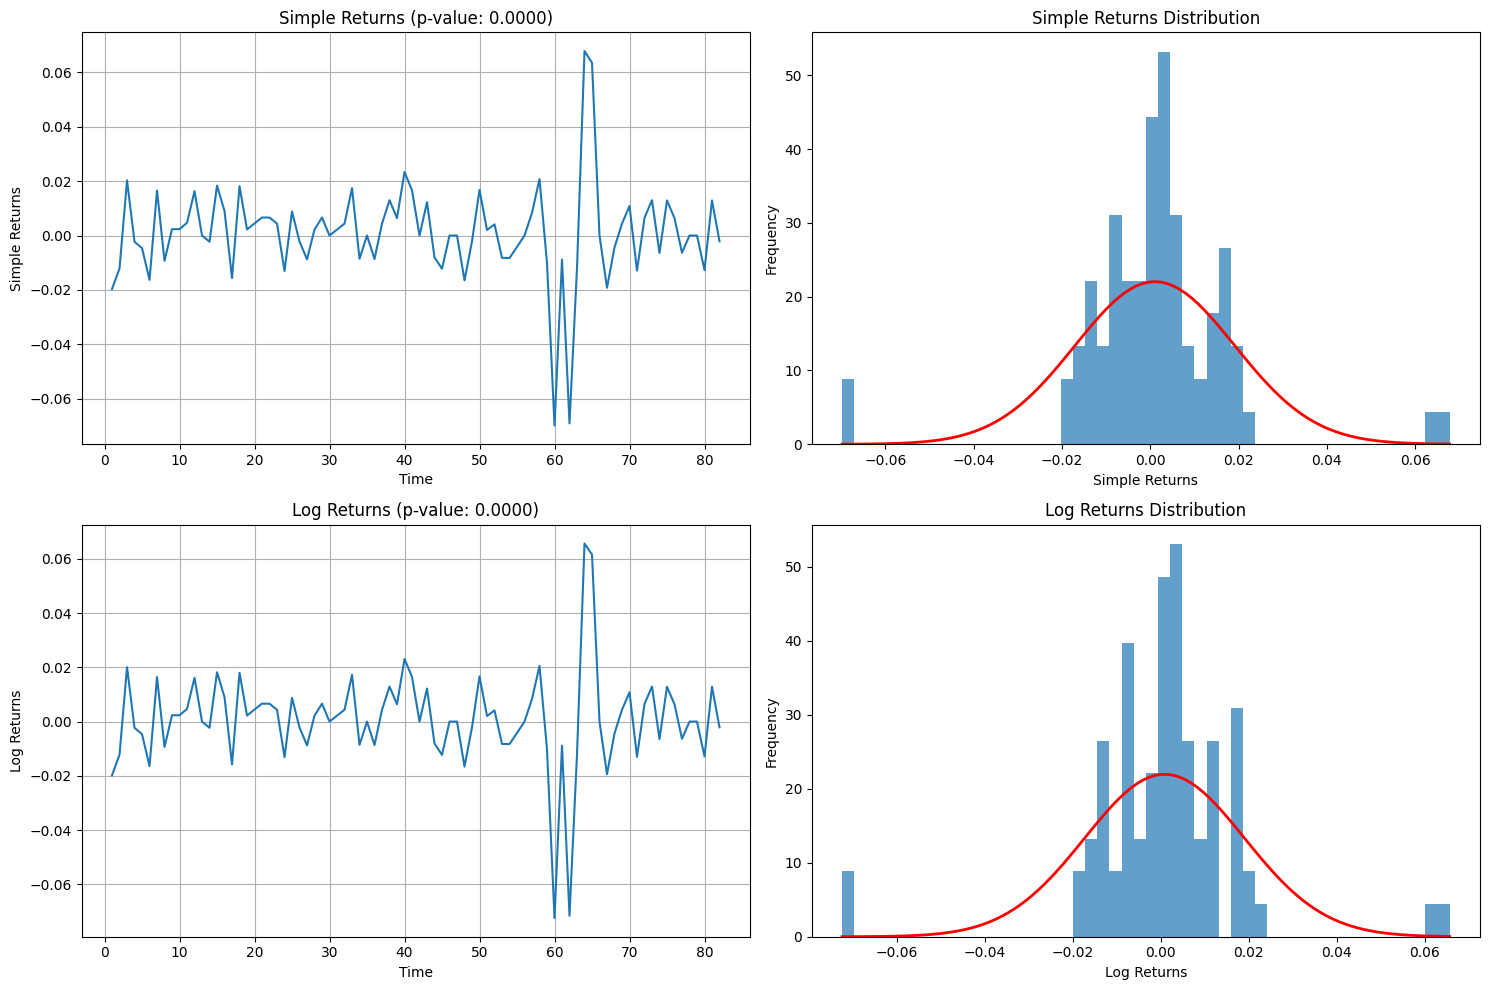

Simple returns ADF test p-value: 0.0000
Log returns ADF test p-value: 0.0000

Interpretation:
p-value < 0.05 indicates stationarity
p-value >= 0.05 indicates non-stationarity


In [32]:
def analyze_stock_returns(df):
    """
    Analyze and visualize stock returns before and after log transformation
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing stock data with 'close' column
    """
    # Sort data by time
    df = df.sort_values(by="time")
    
    # Calculate simple returns and log returns
    df['simple_return'] = df['close'].pct_change()
    df['log_return'] = np.log(df['close'] / df['close'].shift(1))
    simple_returns = df['simple_return'].dropna()
    log_returns = df['log_return'].dropna()
    
    # Perform stationarity tests
    simple_test = adfuller(simple_returns)
    simple_pvalue = simple_test[1]
    
    log_test = adfuller(log_returns)
    log_pvalue = log_test[1]
    
    # Create figure with 2x2 subplots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    
    # Plot simple returns
    ax1.plot(simple_returns)
    ax1.set_title(f'Simple Returns (p-value: {simple_pvalue:.4f})')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Simple Returns')
    ax1.grid(True)
    
    # Plot simple returns histogram with normal curve
    ax2.hist(simple_returns, bins=50, density=True, alpha=0.7)
    x = np.linspace(simple_returns.min(), simple_returns.max(), 100)
    mu = simple_returns.mean()
    sigma = simple_returns.std()
    ax2.plot(x, stats.norm.pdf(x, mu, sigma), 'r-', lw=2)
    ax2.set_title('Simple Returns Distribution')
    ax2.set_xlabel('Simple Returns')
    ax2.set_ylabel('Frequency')
    
    # Plot log returns
    ax3.plot(log_returns)
    ax3.set_title(f'Log Returns (p-value: {log_pvalue:.4f})')
    ax3.set_xlabel('Time')
    ax3.set_ylabel('Log Returns')
    ax3.grid(True)
    
    # Plot log returns histogram with normal curve
    ax4.hist(log_returns, bins=50, density=True, alpha=0.7)
    x = np.linspace(log_returns.min(), log_returns.max(), 100)
    mu = log_returns.mean()
    sigma = log_returns.std()
    ax4.plot(x, stats.norm.pdf(x, mu, sigma), 'r-', lw=2)
    ax4.set_title('Log Returns Distribution')
    ax4.set_xlabel('Log Returns')
    ax4.set_ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()
    
    # Print stationarity test results
    print(f"Simple returns ADF test p-value: {simple_pvalue:.4f}")
    print(f"Log returns ADF test p-value: {log_pvalue:.4f}")
    print("\nInterpretation:")
    print("p-value < 0.05 indicates stationarity")
    print("p-value >= 0.05 indicates non-stationarity")
    
    return log_returns

# Example usage:
returns = analyze_stock_returns(df)

In [33]:
mu_r = returns.mean()
sigma_r = returns.std()
print(f"Profit_expected_day: {mu_r*252:.6f}")
print(f"Standard_dev_day: {sigma_r*np.sqrt(252):.6f}")


Profit_expected_day: 0.215298
Standard_dev_day: 0.288312


In [34]:
def monte_carlo_simulation(df, mu_r, sigma_r, days_list=[15, 16, 20, 180, 252], simulations=1000000):
    """
    Perform Monte Carlo simulation for multiple time horizons
    
    Parameters:
    -----------
    df : DataFrame
        Input dataframe containing price data
    mu_r : float
        Mean of log returns
    sigma_r : float
        Standard deviation of log returns
    days_list : list
        List of days to simulate
    simulations : int
        Number of simulations to run
        
    Returns:
    --------
    dict
        Dictionary containing results for each time horizon
    """
    start_price = df['close'].iloc[-1]
    results = {}
    
    for days in days_list:
        # Simulate random log returns
        simulated_returns = np.random.normal(mu_r, sigma_r, (simulations, days))
        
        # Calculate future prices from log returns
        price_paths = start_price * np.exp(np.cumsum(simulated_returns, axis=1))
        final_prices = price_paths[:, -1]
        returns = (final_prices - start_price) / start_price
        
        # Calculate statistics
        results[days] = {
            'expected_return': np.mean(returns),
            'risk': np.std(returns),
            'VaR_5': np.percentile(returns, 5),
            'price_paths': price_paths
        }
        
        # Print results
        print(f"\nResults for {days} days:")
        print(f"Lợi nhuận kỳ vọng: {results[days]['expected_return']:.2%}")
        print(f"Độ lệch chuẩn lợi nhuận (Rủi ro): {results[days]['risk']:.2%}")
        print(f"Value-at-Risk (VaR 5%): {results[days]['VaR_5']:.2%}")
    
    return results

# Example usage:
results = monte_carlo_simulation(df, mu_r, sigma_r)


Results for 15 days:
Lợi nhuận kỳ vọng: 1.54%
Độ lệch chuẩn lợi nhuận (Rủi ro): 7.15%
Value-at-Risk (VaR 5%): -9.76%

Results for 16 days:
Lợi nhuận kỳ vọng: 1.65%
Độ lệch chuẩn lợi nhuận (Rủi ro): 7.40%
Value-at-Risk (VaR 5%): -10.04%

Results for 20 days:
Lợi nhuận kỳ vọng: 2.06%
Độ lệch chuẩn lợi nhuận (Rủi ro): 8.30%
Value-at-Risk (VaR 5%): -11.00%

Results for 180 days:
Lợi nhuận kỳ vọng: 20.16%
Độ lệch chuẩn lợi nhuận (Rủi ro): 29.71%
Value-at-Risk (VaR 5%): -21.89%

Results for 252 days:
Lợi nhuận kỳ vọng: 29.23%
Độ lệch chuẩn lợi nhuận (Rủi ro): 38.02%
Value-at-Risk (VaR 5%): -22.81%
